In [3]:
# Breast Cancer Diagnosis Classification Using Support Vector Machines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# ## 1. Reading the Data

# Load the dataset
df = pd.read_csv('breastcancer.csv')


Dataset Shape: (569, 32)

Column Names and Types:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compa

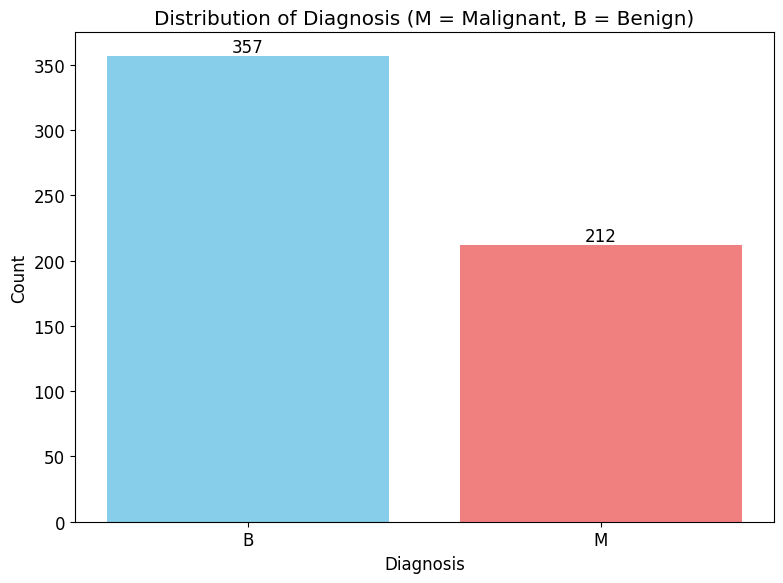

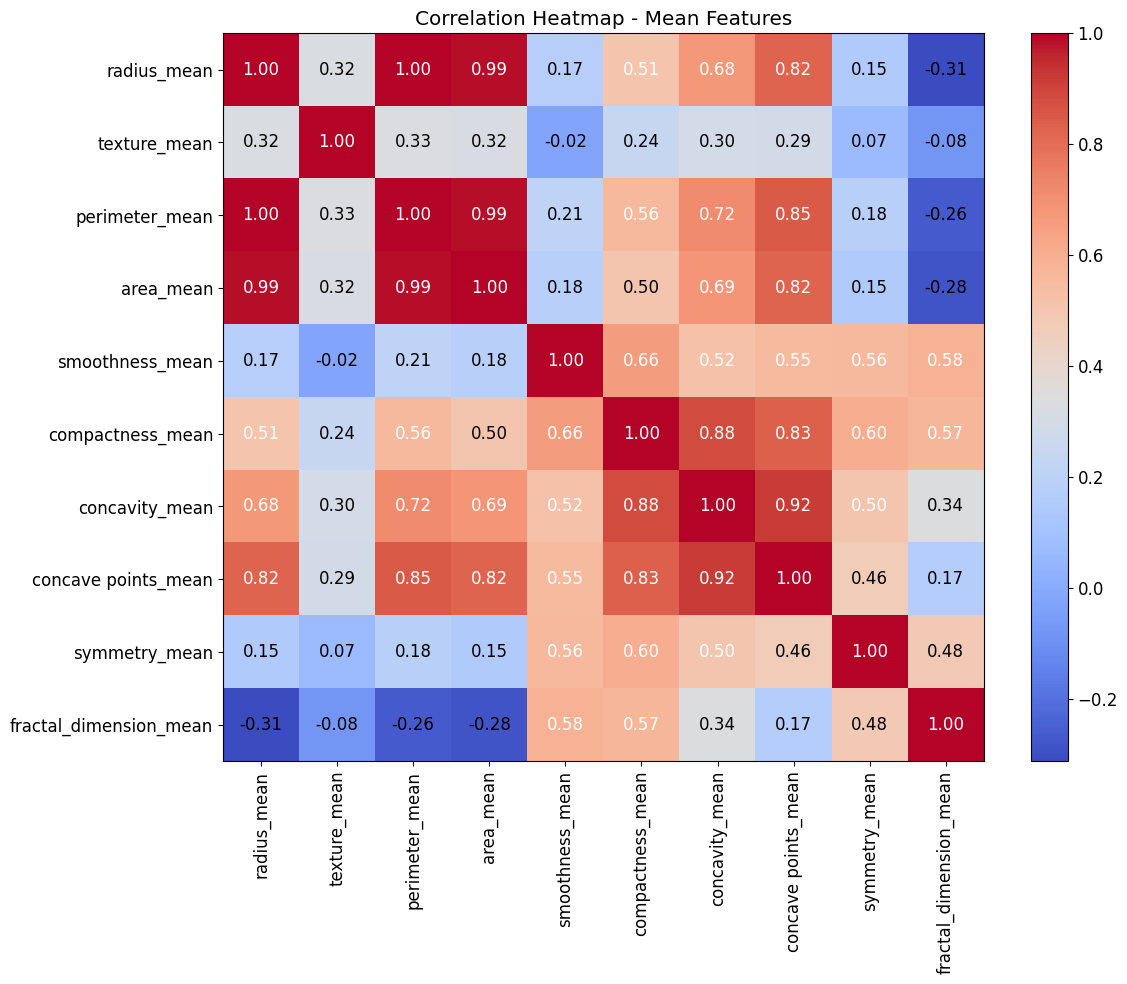

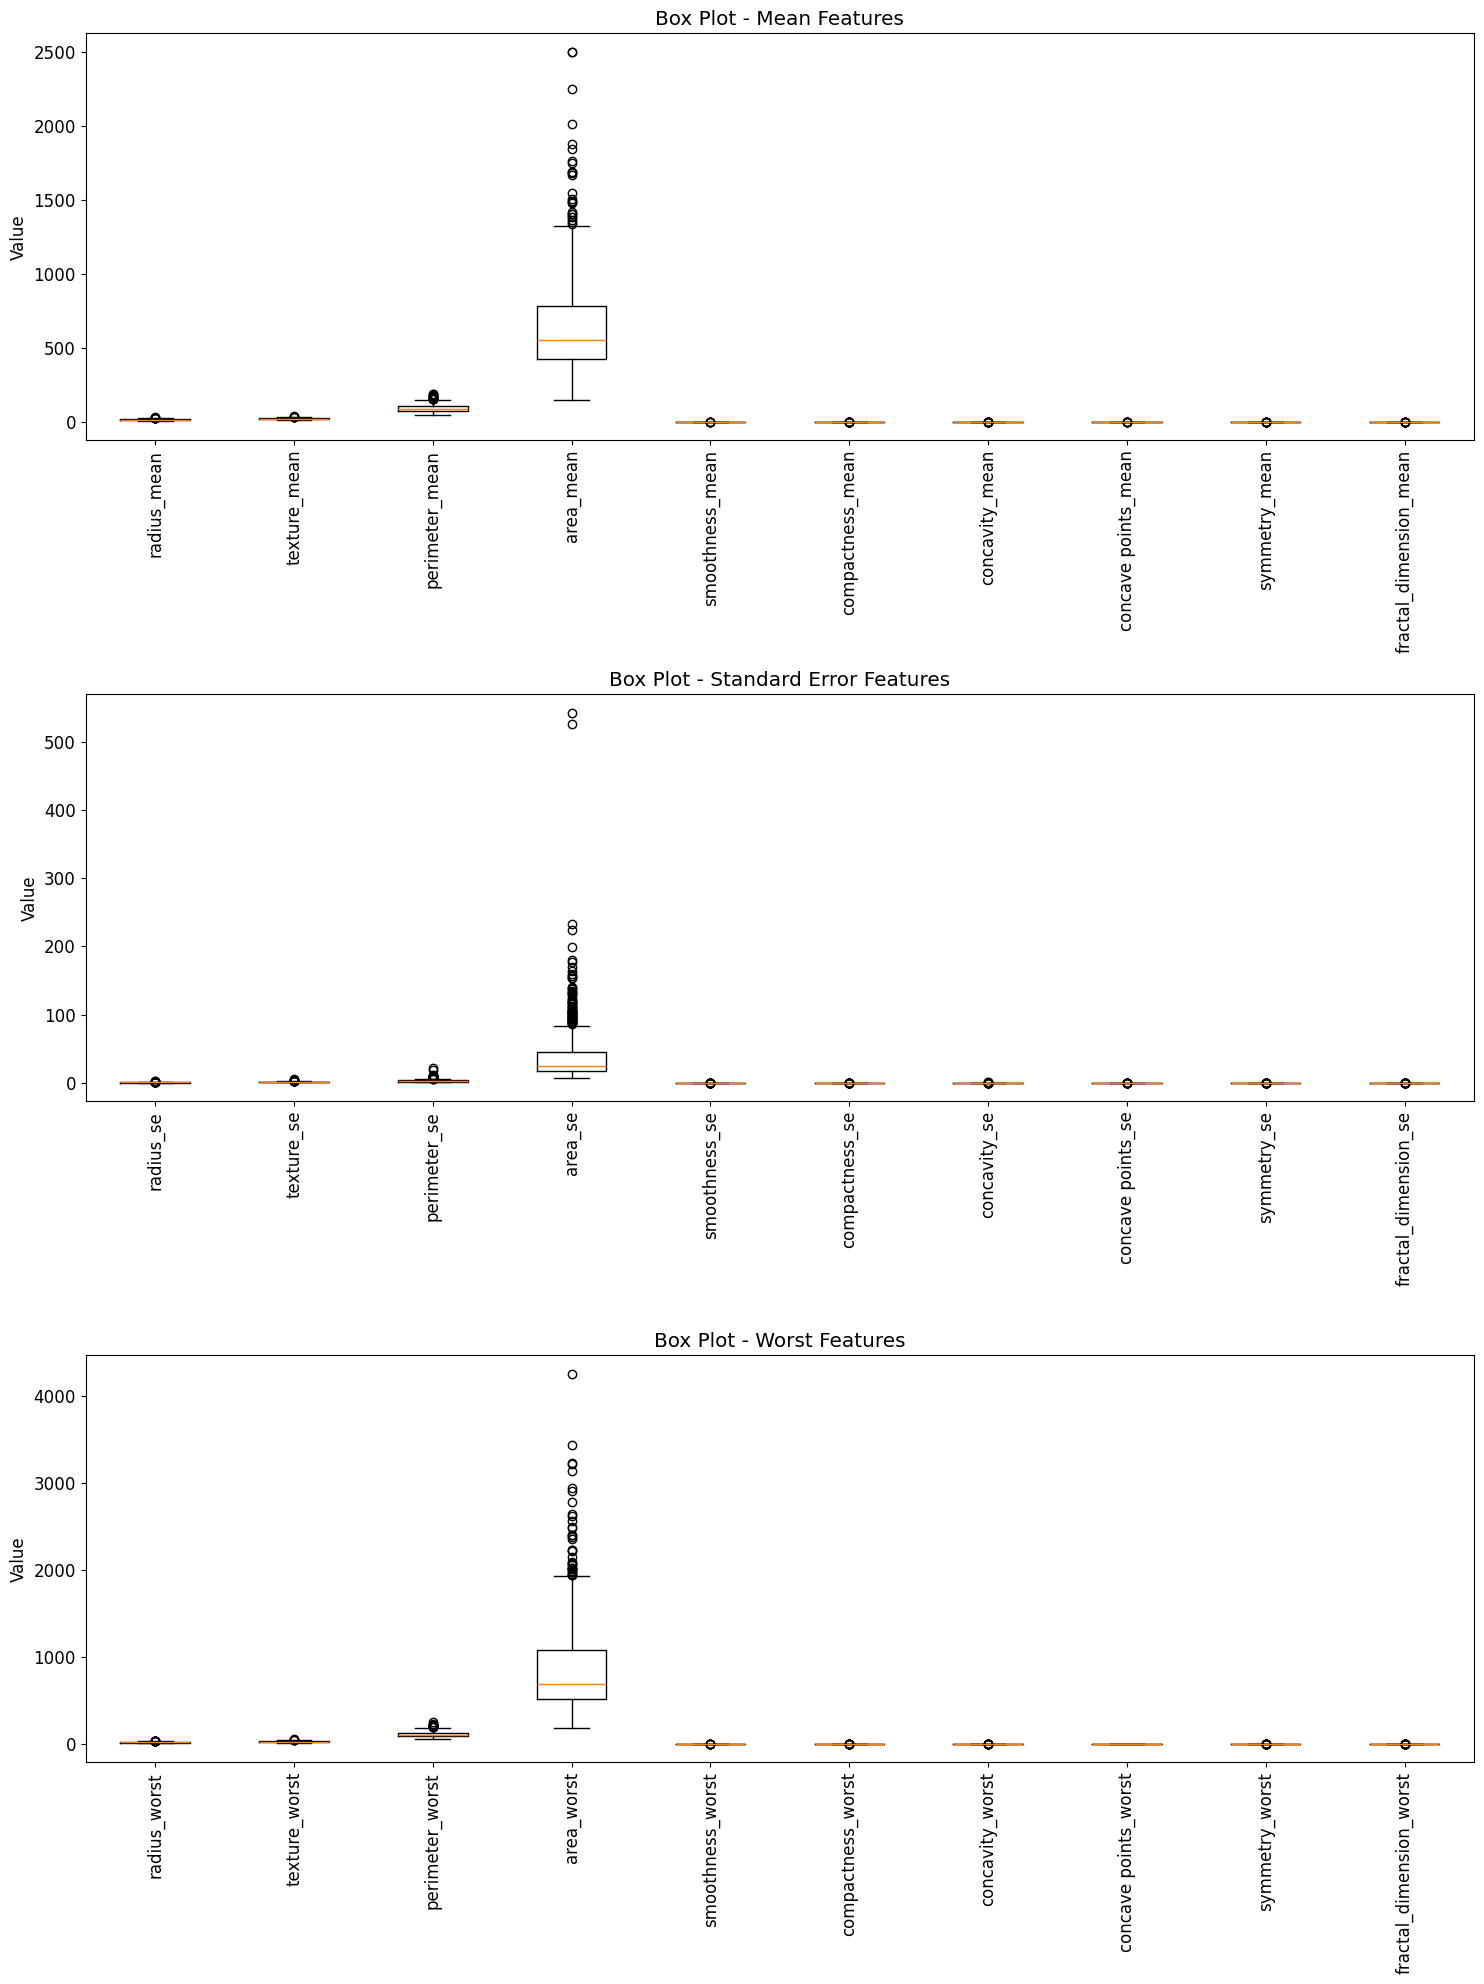

In [4]:

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names and Types:")
print(df.dtypes)

# Display first few rows
df.head()

# ## 2. Data Cleaning and Exploration

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

# Check the distribution of the target variable
print("\nDiagnosis distribution:")
print(df['diagnosis'].value_counts())
print(df['diagnosis'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 6))
diagnosis_counts = df['diagnosis'].value_counts()
bars = plt.bar(diagnosis_counts.index, diagnosis_counts.values, color=['skyblue', 'lightcoral'])
plt.title('Distribution of Diagnosis (M = Malignant, B = Benign)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Drop the 'id' column as it's not useful for prediction
df = df.drop('id', axis=1)

# Convert diagnosis to binary (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# ## 3. Exploratory Data Analysis and Visualizations

# Create a copy for exploratory analysis
df_viz = df.copy()

# Separate features by category
mean_cols = [col for col in df.columns if '_mean' in col]
se_cols = [col for col in df.columns if '_se' in col]
worst_cols = [col for col in df.columns if '_worst' in col]

# Correlation heatmap for mean features
plt.figure(figsize=(12, 10))
correlation_matrix = df[mean_cols].corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(im)
plt.xticks(range(len(mean_cols)), mean_cols, rotation=90)
plt.yticks(range(len(mean_cols)), mean_cols)
plt.title('Correlation Heatmap - Mean Features')
for i in range(len(mean_cols)):
    for j in range(len(mean_cols)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black' if abs(correlation_matrix.iloc[i, j]) < 0.5 else 'white')
plt.tight_layout()
plt.show()

# Box plots to check for outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, feature_group in enumerate([mean_cols, se_cols, worst_cols]):
    data_to_plot = df[feature_group]
    axes[i].boxplot([data_to_plot[col] for col in feature_group], labels=feature_group)
    axes[i].set_title(f'Box Plot - {["Mean", "Standard Error", "Worst"][i]} Features')
    axes[i].set_ylabel('Value')
    axes[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()


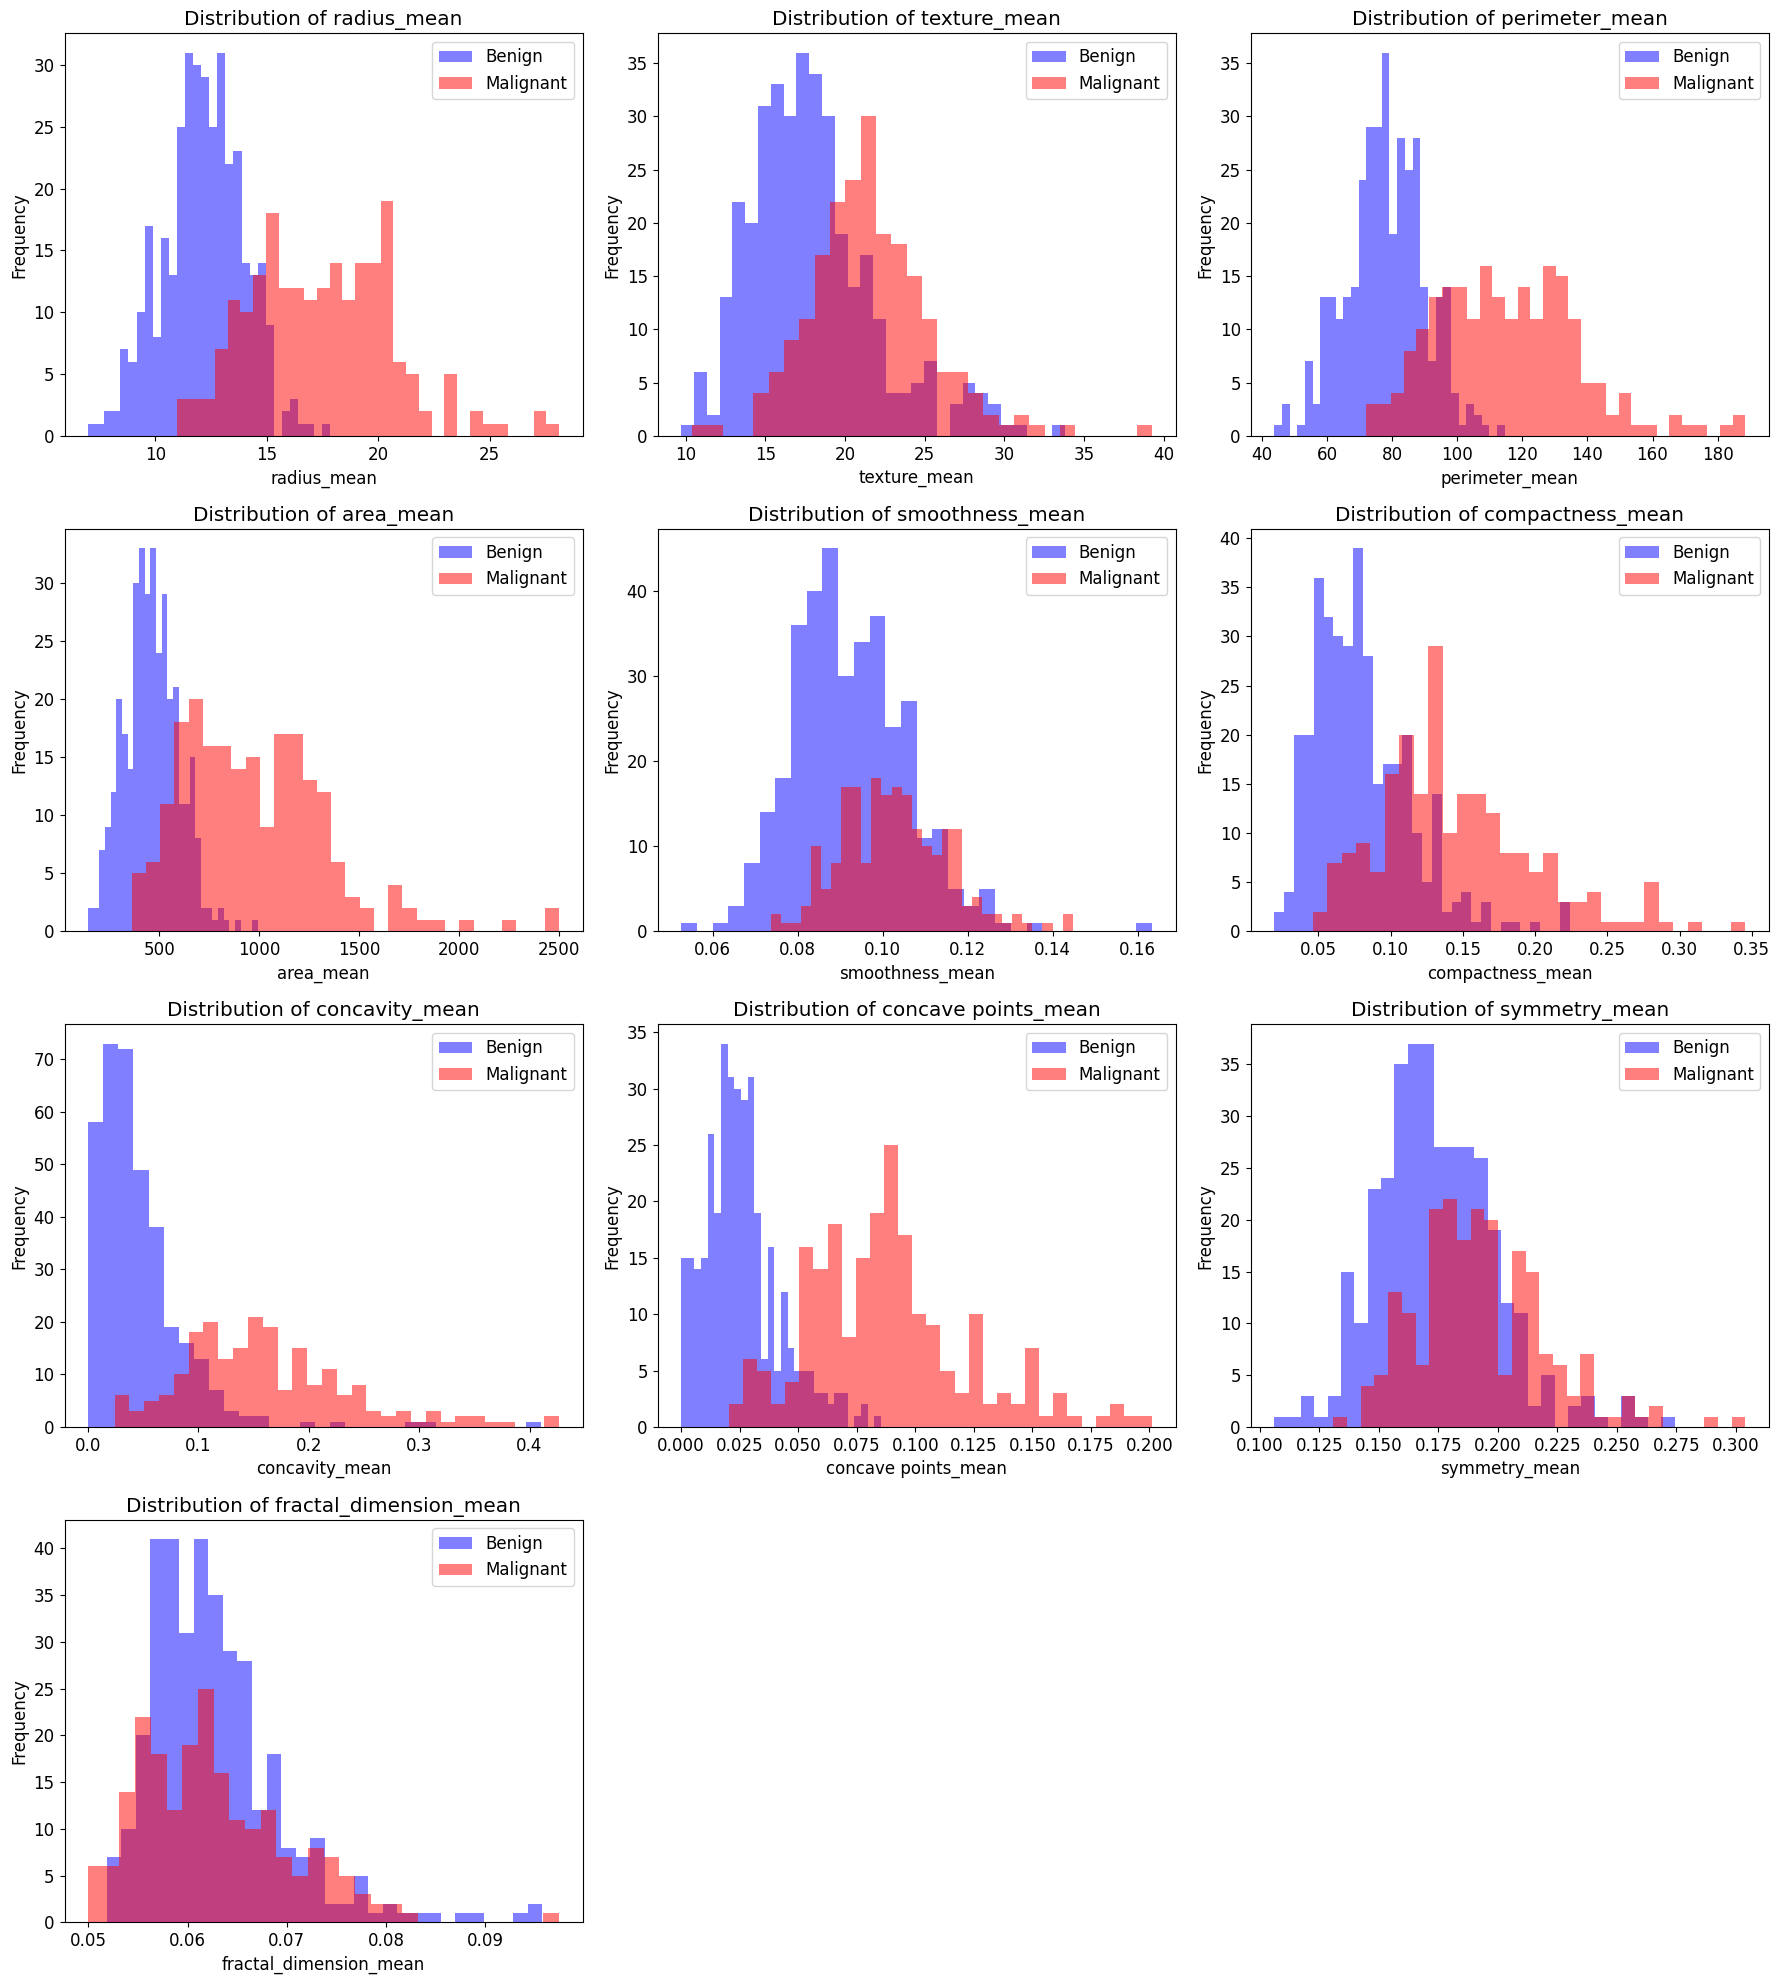

Features with most outliers:
                    Feature  Outlier_Count
13                  area_se             65
10                radius_se             38
12             perimeter_se             38
23               area_worst             35
14            smoothness_se             30
15           compactness_se             28
19     fractal_dimension_se             28
18              symmetry_se             27
3                 area_mean             25
29  fractal_dimension_worst             24


In [5]:

# Distribution plots for mean features
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.ravel()

for idx, col in enumerate(mean_cols):
    if idx < len(axes):
        ax = axes[idx]
        # Plot histogram for benign cases
        ax.hist(df[df['diagnosis'] == 0][col], bins=30, alpha=0.5, label='Benign', color='blue')
        # Plot histogram for malignant cases
        ax.hist(df[df['diagnosis'] == 1][col], bins=30, alpha=0.5, label='Malignant', color='red')
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend()

# Hide empty subplots
for idx in range(len(mean_cols), len(axes)):
    axes[idx].set_visible(False)
    
plt.tight_layout()
plt.show()

# Check for extreme outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Count outliers for each feature
outlier_counts = {}
for col in df.columns[1:]:  # Skip diagnosis column
    outliers = detect_outliers_iqr(df, col)
    outlier_counts[col] = len(outliers)

# Display features with most outliers
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier_Count'])
outlier_df = outlier_df.sort_values('Outlier_Count', ascending=False)
print("Features with most outliers:")
print(outlier_df.head(10))


Features with high skewness (abs > 1):
area_se                    5.447186
concavity_se               5.110463
fractal_dimension_se       3.923969
perimeter_se               3.443615
radius_se                  3.088612
smoothness_se              2.314450
symmetry_se                2.195133
compactness_se             1.902221
area_worst                 1.859373
fractal_dimension_worst    1.662579
texture_se                 1.646444
area_mean                  1.645732
compactness_worst          1.473555
concave points_se          1.444678
symmetry_worst             1.433928
concavity_mean             1.401180
fractal_dimension_mean     1.304489
compactness_mean           1.190123
concave points_mean        1.171180
concavity_worst            1.150237
perimeter_worst            1.128164
radius_worst               1.103115
dtype: float64

Skewness after log transformation:
area_mean                  0.287328
compactness_mean           1.043195
concavity_mean             1.206982
concave p

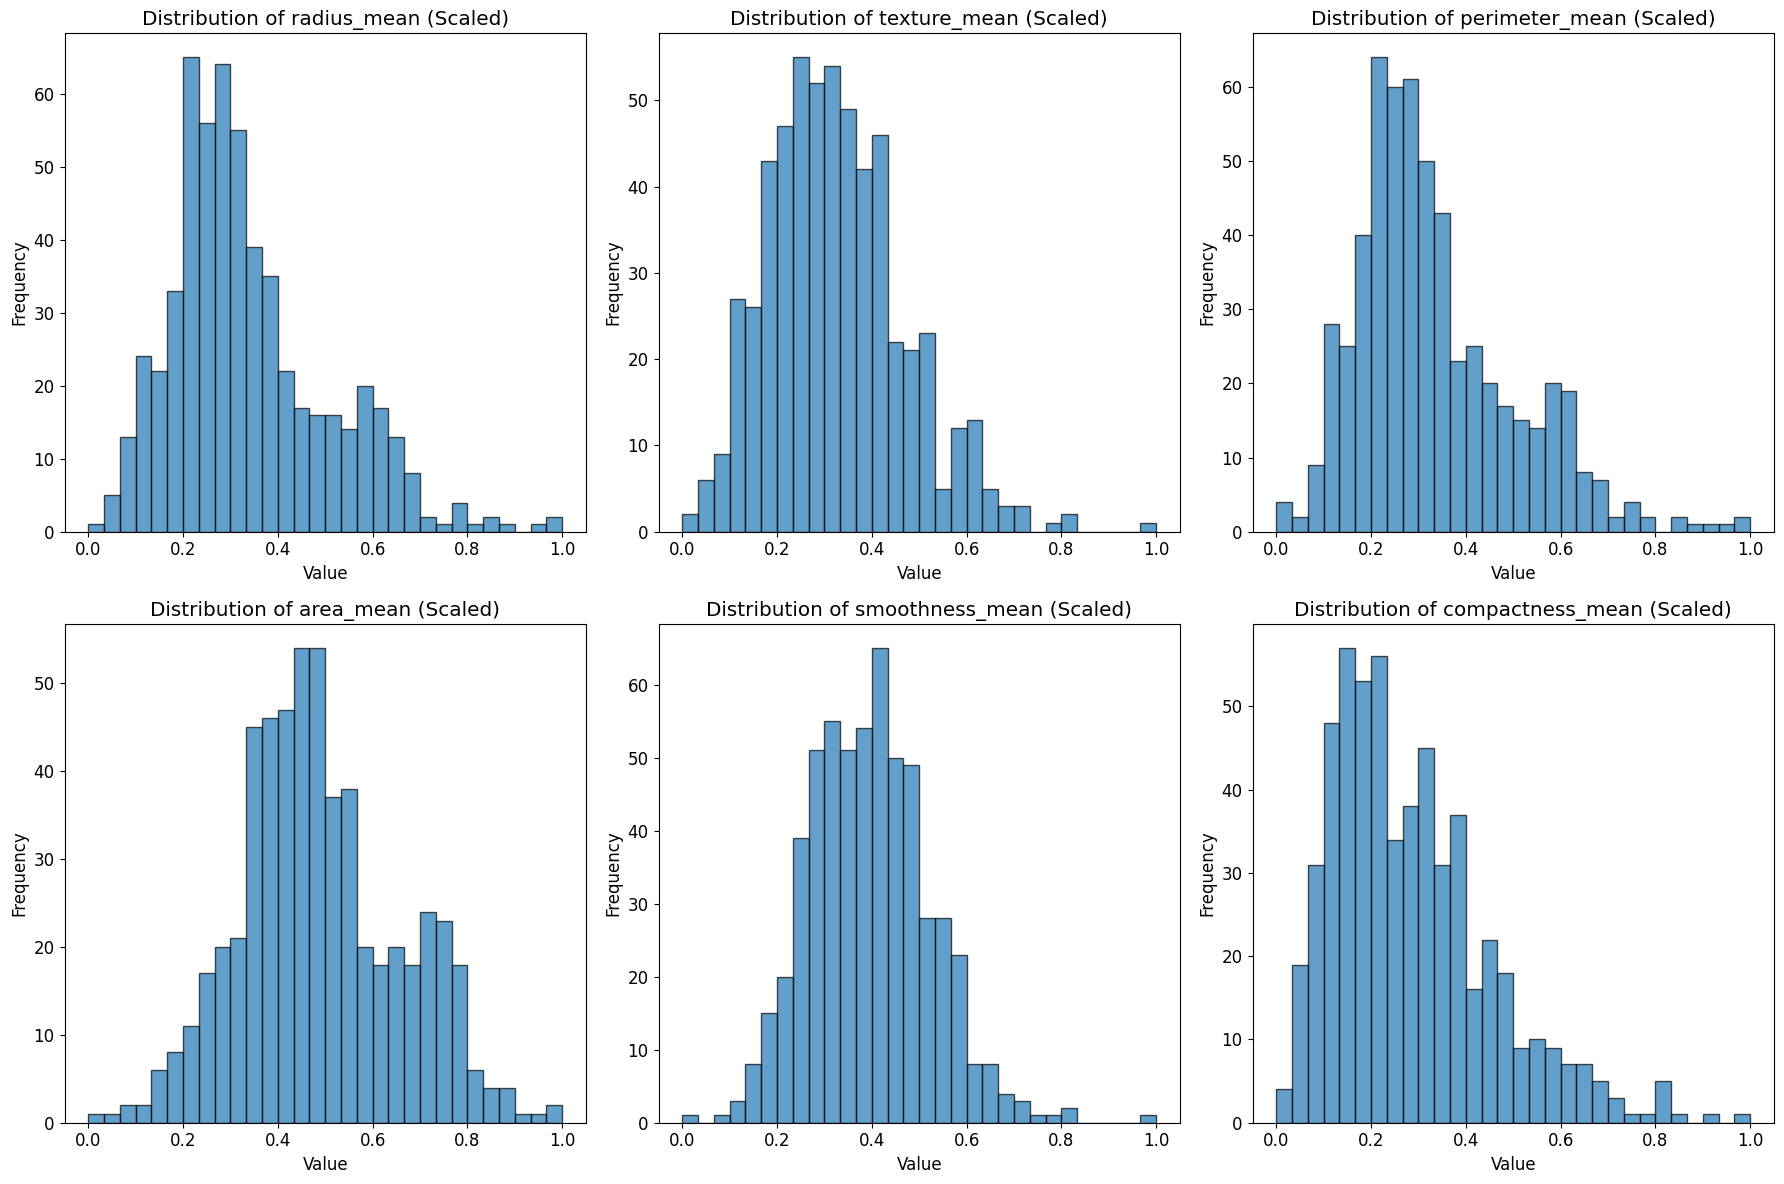

In [6]:


# ## 4. Data Transformation and Scaling

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Check skewness of features
skewness = X.skew()
print("\nFeatures with high skewness (abs > 1):")
print(skewness[abs(skewness) > 1].sort_values(ascending=False))

# Apply log transformation to highly skewed features to reduce skewness
skewed_features = skewness[abs(skewness) > 1].index
for feature in skewed_features:
    # Add 1 to avoid log(0)
    X[feature] = np.log1p(X[feature])

# Verify reduced skewness
print("\nSkewness after log transformation:")
new_skewness = X[skewed_features].skew()
print(new_skewness)

# Apply Min-Max scaling to normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Visualize distributions after scaling
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(X_scaled.columns[:6]):
    ax = axes[idx]
    ax.hist(X_scaled[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col} (Scaled)')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [7]:

# ## 5. Feature Selection

# Use SelectKBest with ANOVA F-value for feature selection
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print("\nTop 10 features selected by ANOVA F-value:")
print(selected_features.tolist())

# Use Recursive Feature Elimination with SVM
svm_rfe = SVC(kernel='linear')
rfe_selector = RFE(estimator=svm_rfe, n_features_to_select=10, step=1)
rfe_selector.fit(X_scaled, y)

# Get RFE selected features
rfe_selected_features = X.columns[rfe_selector.support_]
print("\nTop 10 features selected by RFE:")
print(rfe_selected_features.tolist())

# Find common features between both methods
common_features = list(set(selected_features) & set(rfe_selected_features))
print(f"\nCommon features selected by both methods ({len(common_features)}):")
print(common_features)

# Use the union of both feature selection methods
final_features = list(set(selected_features) | set(rfe_selected_features))
X_final = X_scaled[final_features]


Top 10 features selected by ANOVA F-value:
['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']

Top 10 features selected by RFE:
['area_mean', 'concave points_mean', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concave points_worst', 'symmetry_worst']

Common features selected by both methods (7):
['perimeter_worst', 'concave points_worst', 'area_se', 'radius_worst', 'area_worst', 'concave points_mean', 'area_mean']


In [8]:
# ## 6. Data Splitting

# Split the data into train (70%), validation (15%), and test (15%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_final, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (397, 13)
Validation set shape: (86, 13)
Test set shape: (86, 13)


In [9]:
# ## 7. Model Training and Hyperparameter Tuning

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4],  # Only used for poly kernel
    'class_weight': [None, 'balanced']
}

# Create the SVM classifier
svm = SVC(probability=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_svm = grid_search.best_estimator_

# Evaluate on validation set
val_pred = best_svm.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"\nValidation accuracy: {val_accuracy:.4f}")

# Create a more focused grid search based on initial results
refined_param_grid = {
    'C': [0.5, 1, 2, 5],
    'kernel': [grid_search.best_params_['kernel']],
    'gamma': [0.1, 0.5, 1, 'scale'],
    'class_weight': [None, 'balanced']
}

# Perform refined grid search
refined_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=refined_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

refined_grid_search.fit(X_train, y_train)

# Get the final best model
final_best_svm = refined_grid_search.best_estimator_


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters found:
{'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best cross-validation accuracy: 0.9722

Validation accuracy: 0.9884
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Test accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        54
   Malignant       1.00      1.00      1.00        32

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



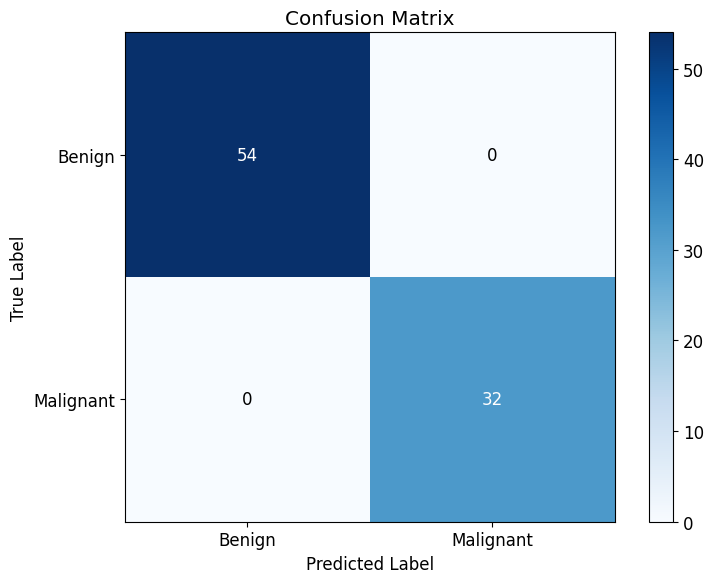

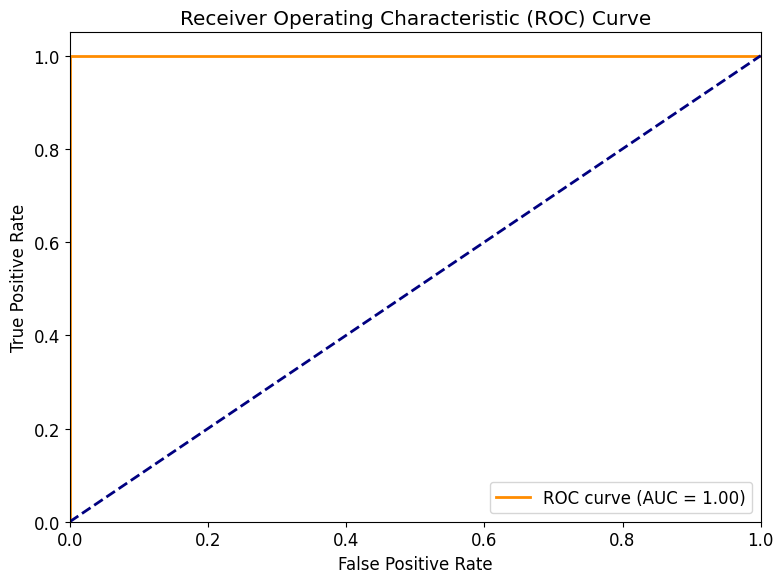

In [10]:
# ## 8. Model Evaluation on Test Set

# Make predictions on test set
y_pred = final_best_svm.predict(X_test)
y_pred_proba = final_best_svm.predict_proba(X_test)[:, 1]

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar(im)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

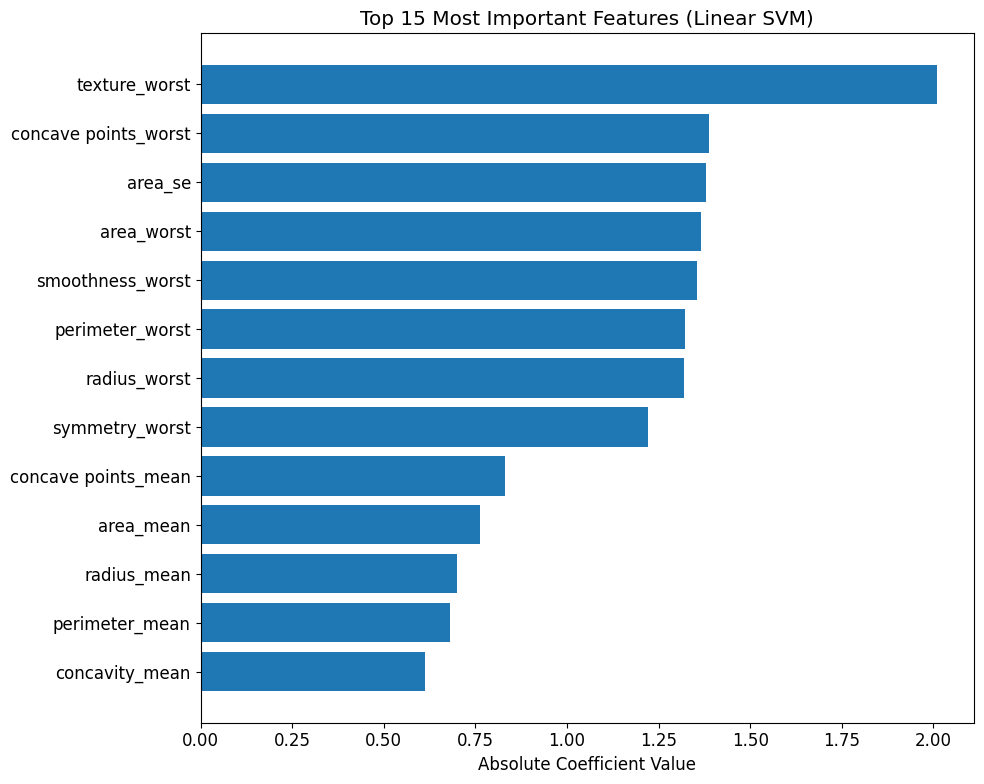

In [11]:
# ## 9. Feature Importance Analysis

# For linear kernel SVM, we can extract feature coefficients
if grid_search.best_params_['kernel'] == 'linear':
    # Get feature importance from coefficients
    feature_importance = np.abs(final_best_svm.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 15 Most Important Features (Linear SVM)')
    plt.gca().invert_yaxis()  # To display most important at the top
    plt.tight_layout()
    plt.show()
else:
    # For non-linear kernels, use permutation importance
    from sklearn.inspection import permutation_importance
    
    perm_importance = permutation_importance(final_best_svm, X_test, y_test, n_repeats=10, random_state=42)
    
    feature_importance_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
    plt.xlabel('Mean Decrease in Accuracy')
    plt.title('Top 15 Most Important Features (Permutation Importance)')
    plt.gca().invert_yaxis()  # To display most important at the top
    plt.tight_layout()
    plt.show()


Model Performance Comparison:
                 Model  CV Mean Accuracy    CV Std  Test Accuracy
0                  SVM          0.969684  0.017190       1.000000
1  Logistic Regression          0.952089  0.020310       0.988372
2        Random Forest          0.954684  0.015056       0.988372
3                  KNN          0.952089  0.012495       0.976744
4          Naive Bayes          0.932089  0.025600       0.976744


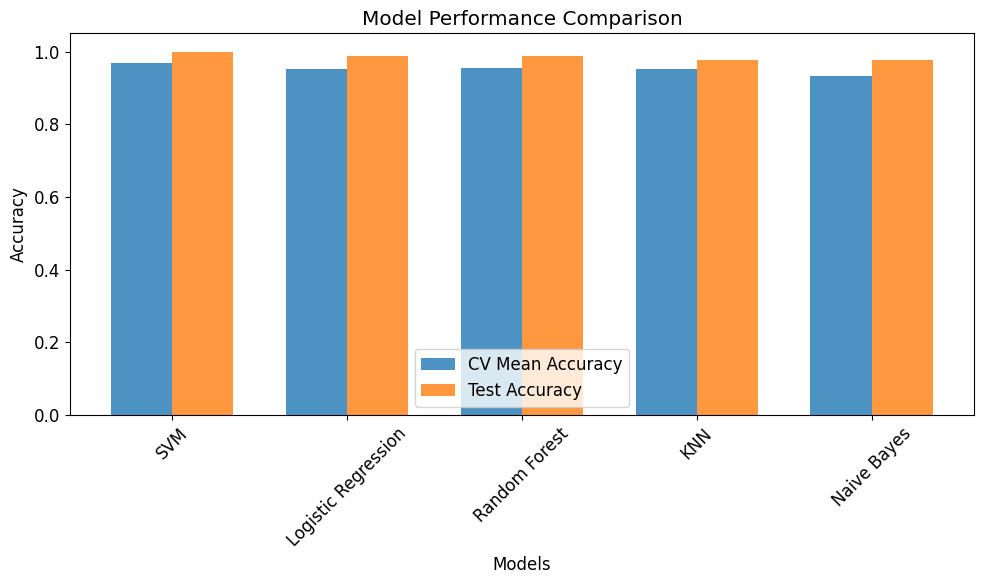

In [12]:
# ## 10. Performance Comparison with Other Models

# Compare with other classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Define models to compare
models = {
    'SVM': final_best_svm,
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Compare performance
results = []
for name, model in models.items():
    if name != 'SVM':  # SVM is already trained
        model.fit(X_train, y_train)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Test set performance
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    
    results.append({
        'Model': name,
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_acc
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\nModel Performance Comparison:")
print(comparison_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['CV Mean Accuracy'], width, label='CV Mean Accuracy', alpha=0.8)
plt.bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test Accuracy', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

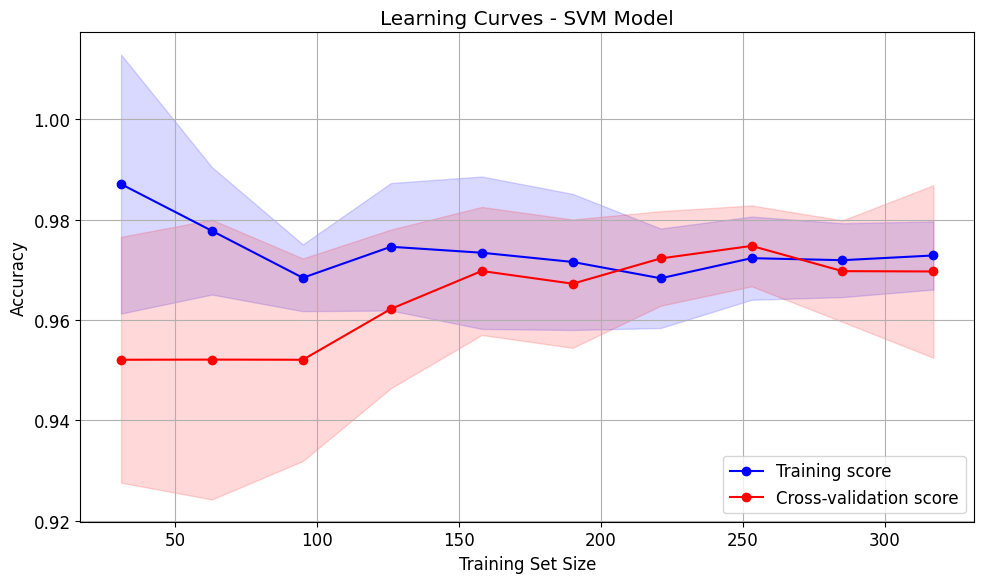

=== Final Model Summary ===
Best SVM Parameters: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'linear'}
Test Accuracy: 1.0000
ROC AUC Score: 1.0000
Number of features used: 13

Selected features:
['perimeter_worst', 'concave points_worst', 'area_se', 'smoothness_worst', 'perimeter_mean', 'radius_mean', 'area_worst', 'area_mean', 'symmetry_worst', 'texture_worst', 'concavity_mean', 'radius_worst', 'concave points_mean']

Model and scaler saved successfully!


In [13]:
# ## 11. Learning Curves

from sklearn.model_selection import learning_curve

# Generate learning curves for the best SVM model
train_sizes, train_scores, val_scores = learning_curve(
    final_best_svm, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves - SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ## 12. Final Summary

print("=== Final Model Summary ===")
print(f"Best SVM Parameters: {refined_grid_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Number of features used: {len(final_features)}")
print("\nSelected features:")
print(final_features)

# Save the best model and scaler for future use
import joblib

joblib.dump(final_best_svm, 'breast_cancer_svm_model.joblib')
joblib.dump(scaler, 'breast_cancer_scaler.joblib')

print("\nModel and scaler saved successfully!")